In [23]:
import pandas as pd 
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os
from db import query_to_df


### Purpose
In this notebook we look to analyse a teams previous performance in the league and how this may affect their performance in the next season. We will look at the following:
- What stats are most impactful in determinig a teams performance?
- How does a teams performance in the previous season affect their performance in the next season?
- How does a teams performance in the previous season affect their performance in the next season when we take into account the stats that are most impactful?
- Do teams with certain types of players match up against each other well
- Can we apply a weighting to a teams players to determine the strength of a team when they come up against another team?

In [24]:
# Get all the teams from the teams table
teams = query_to_df("SELECT * FROM teams")
# Only keep name and provider_id columns

teams

,id,provider_id,name,abbreviation,nickname
0,1,CD_T10,Adelaide Crows,ADEL,Crows
1,2,CD_T20,Brisbane Lions,BL,Lions
2,3,CD_T40,Collingwood,COLL,Magpies
3,4,CD_T1000,Gold Coast Suns,GCFC,Suns
4,5,CD_T30,Carlton,CARL,Blues
5,6,CD_T100,North Melbourne,NMFC,Kangaroos
6,7,CD_T110,Port Adelaide,PORT,Power
7,8,CD_T140,Western Bulldogs,WB,Bulldogs
8,9,CD_T80,Hawthorn,HAW,Hawks
9,10,CD_T70,Geelong Cats,GEEL,Cats


In [25]:
# Set team variables for anaylsis
team_abbreviation = 'BL'

# Get seasons from the seasons table
seasons = query_to_df("SELECT * FROM afl_seasons")

seasons.head()
# ID is used for all basic stats
# Provider_id is used for AFL Stats pro

,id,provider_id,year,name
0,43,CD_S2022014,2022,2022 Toyota AFL Premiership
1,62,CD_S2024014,2024,2024 Toyota AFL Premiership
2,34,CD_S2021014,2021,2021 Toyota AFL Premiership
3,20,CD_S2020014,2020,2020 Toyota AFL Premiership
4,52,CD_S2023014,2023,2023 Toyota AFL Premiership


In [26]:
# Get AFL fixture from the fixtures table
# Fixtures table also includes the results of each game if they have been played
fixture_df = query_to_df("SELECT * FROM afl_fixture WHERE comp_season_id = 52")
fixture_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   id                      216 non-null    int64              
 1   round_id                216 non-null    int64              
 2   comp_season_id          216 non-null    int64              
 3   round_number            216 non-null    int64              
 4   venue                   216 non-null    object             
 5   venue_abbreviation      216 non-null    object             
 6   venue_state             216 non-null    object             
 7   utc_start_time          216 non-null    datetime64[ns, UTC]
 8   status                  216 non-null    object             
 9   home_team_id            216 non-null    int64              
 10  home_team_name          216 non-null    object             
 11  home_team_abbreviation  216 non-null    objec

In [27]:
# Isolate a single team to test with
team = teams[teams['abbreviation'] == team_abbreviation]
team_id = team['id'].values[0]
team_provider_id = team['provider_id'].values[0]

# Filter fixture to only teams games
team_fixture_df = fixture_df[(fixture_df['home_team_id'] == team_id) | (
    fixture_df['away_team_id'] == team_id)]

team_fixture_df.head()

team_fixture_df['home_game'] = np.where(
    team_fixture_df['away_team_abbreviation'] == team_abbreviation, False, True)

# Decide if the team won or lost

team_fixture_df['win'] = np.where(team_fixture_df['home_team_id'] == team_id, team_fixture_df['home_team_total']
                                       > team_fixture_df['away_team_total'], team_fixture_df['away_team_total'] > team_fixture_df['home_team_total'])
team_fixture_df['win_loss'] = np.where(team_fixture_df['win'] == True, 'W', 'L')
team_fixture_df['margin'] = np.where(team_fixture_df['home_game'] == True, team_fixture_df['home_team_total'] - team_fixture_df['away_team_total'], team_fixture_df['away_team_total'] - team_fixture_df['home_team_total'])
team_fixture_df = team_fixture_df[['round_id', 'round_number', 'home_game', 'win_loss', 'margin',
                                   'venue', 'home_team_id', 'home_team_abbreviation', 'home_team_total', 'away_team_id', 'away_team_abbreviation', 'away_team_total']]
team_fixture_df.head()

C:\Users\Kitten\AppData\Local\Temp\ipykernel_1724\46119853.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_fixture_df['home_game'] = np.where(
C:\Users\Kitten\AppData\Local\Temp\ipykernel_1724\46119853.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_fixture_df['win'] = np.where(team_fixture_df['home_team_id'] == team_id, team_fixture_df['home_team_total']
C:\Users\Kitten\AppData\Local\Temp\ipykernel_1724\46119853.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

,round_id,round_number,home_game,win_loss,margin,venue,home_team_id,home_team_abbreviation,home_team_total,away_team_id,away_team_abbreviation,away_team_total
0,780,23,False,W,24,Marvel Stadium,3,COLL,100,2,BL,124
12,781,24,True,W,12,Gabba,2,BL,72,11,STK,60
21,930,25,True,W,48,Gabba,2,BL,123,7,PORT,75
25,945,27,True,W,16,Gabba,2,BL,79,5,CARL,63
26,951,28,False,L,-4,MCG,3,COLL,90,2,BL,86


In [28]:
# Get the round stats for team

query = f'''
SELECT * FROM team_round_stats
WHERE team_id = '{team_provider_id}'
AND year = 2023
'''

team_round_stats_df = query_to_df(query)
team_round_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       26 non-null     int64  
 1   team_id                  26 non-null     object 
 2   team_name                26 non-null     object 
 3   round_number             26 non-null     int64  
 4   behinds                  26 non-null     float64
 5   kicks                    26 non-null     float64
 6   handballs                26 non-null     float64
 7   disposals                26 non-null     float64
 8   marks                    26 non-null     float64
 9   bounces                  26 non-null     float64
 10  tackles                  26 non-null     float64
 11  contested_possessions    26 non-null     float64
 12  uncontested_possessions  26 non-null     float64
 13  total_possessions        26 non-null     float64
 14  inside_50s               26 

In [29]:
team_round_stats_df = team_round_stats_df.drop(columns=['id', 'team_id', 'team_name', 'season_id'])
win_loss_comparison = team_fixture_df.merge(team_round_stats_df, how='left', left_on='round_number', right_on='round_number')

win_loss_comparison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   round_id                 26 non-null     int64  
 1   round_number             26 non-null     int64  
 2   home_game                26 non-null     bool   
 3   win_loss                 26 non-null     object 
 4   margin                   26 non-null     int64  
 5   venue                    26 non-null     object 
 6   home_team_id             26 non-null     int64  
 7   home_team_abbreviation   26 non-null     object 
 8   home_team_total          26 non-null     int64  
 9   away_team_id             26 non-null     int64  
 10  away_team_abbreviation   26 non-null     object 
 11  away_team_total          26 non-null     int64  
 12  behinds                  26 non-null     float64
 13  kicks                    26 non-null     float64
 14  handballs                26 

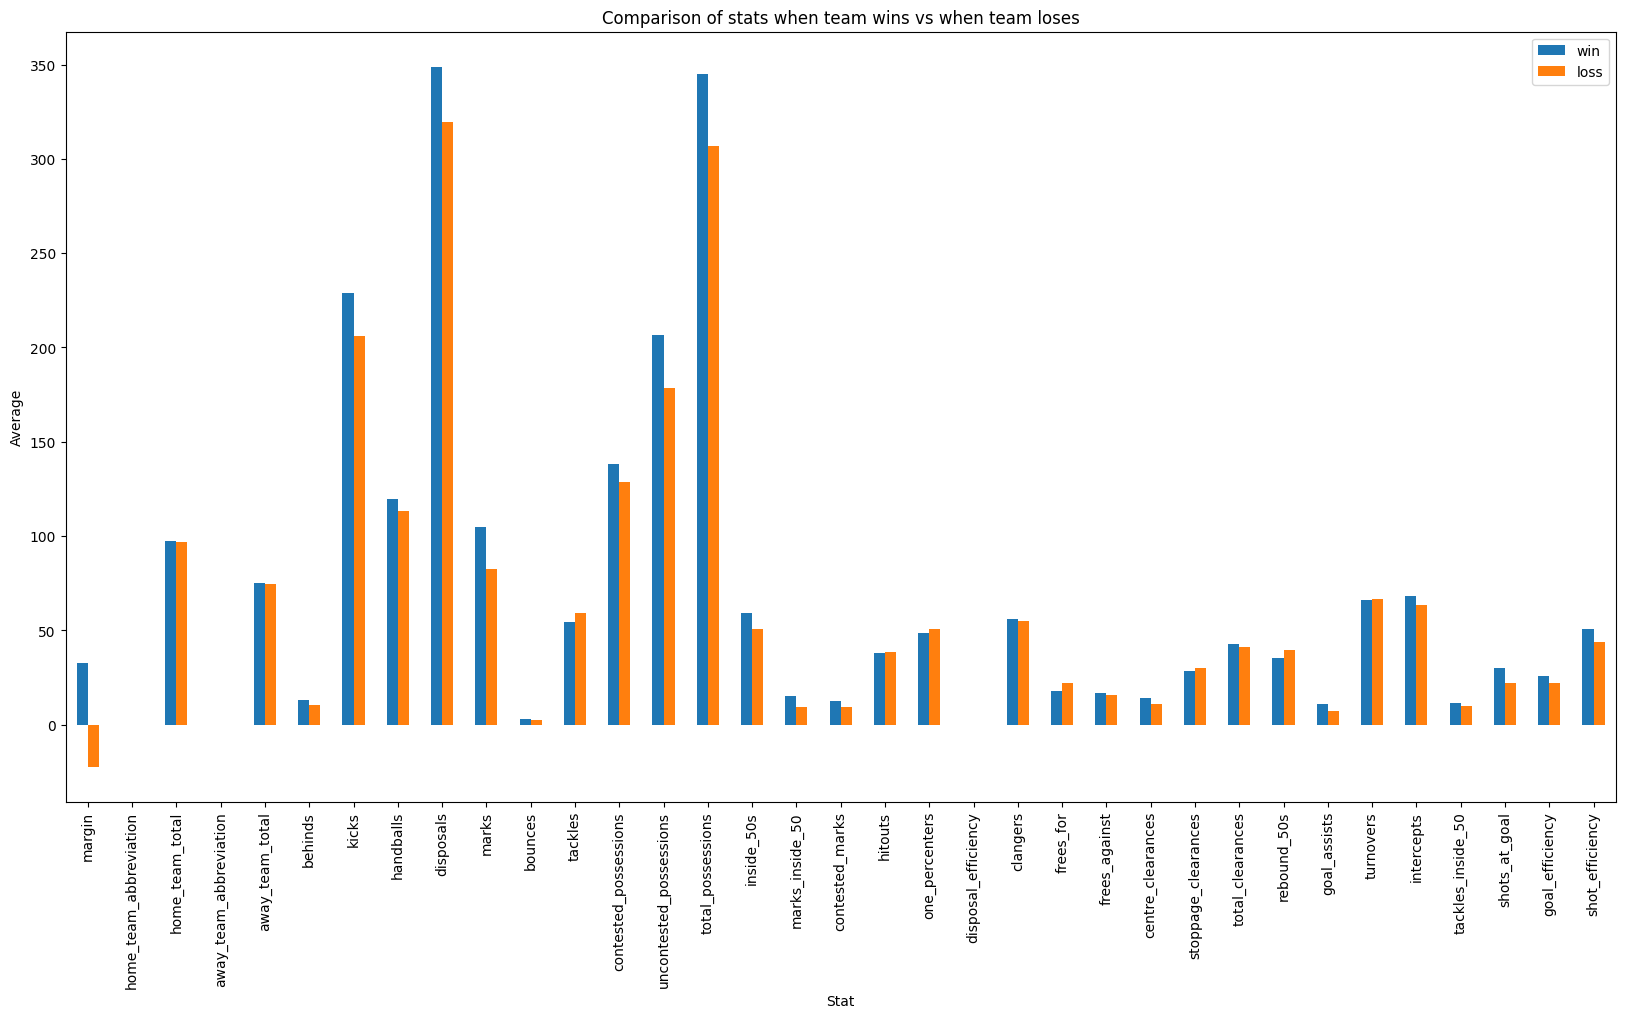

In [30]:
# create a bargraph that shows a comparison of the stats when the team loses vs when they win

# Get the average stats for the team when they win and when they lose
win_stats = win_loss_comparison[win_loss_comparison['win_loss'] == 'W'].apply(pd.to_numeric, errors='coerce').mean()
loss_stats = win_loss_comparison[win_loss_comparison['win_loss'] == 'L'].apply(pd.to_numeric, errors='coerce').mean()

# Create a dataframe with the stats
win_loss_stats = pd.DataFrame({'win': win_stats, 'loss': loss_stats})
win_loss_stats = win_loss_stats.drop(
    ['round_id', 'round_number', 'home_game', 'home_team_id', 'away_team_id', 'venue', 'win_loss', 'year', 'fantasy_points'])

# Create a bar graph
win_loss_stats.plot.bar(figsize=(20, 10))
plt.title('Comparison of stats when team wins vs when team loses')
plt.xlabel('Stat')
plt.ylabel('Average')
plt.show()

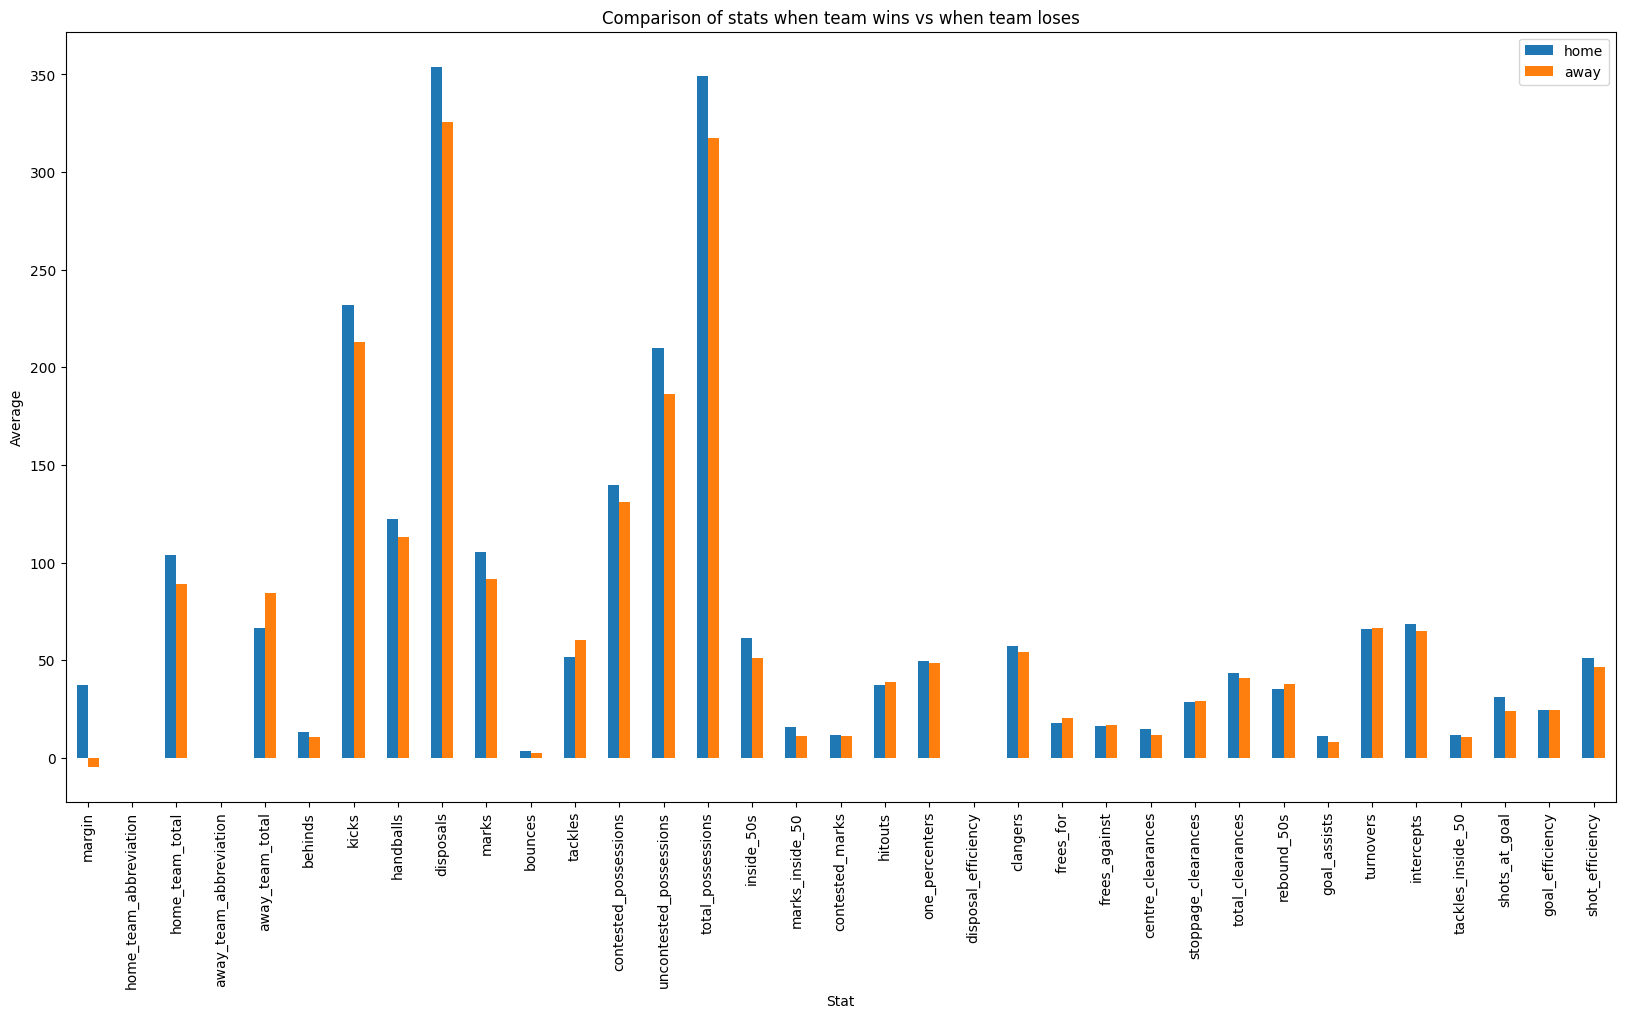

In [31]:
home_stats = win_loss_comparison[win_loss_comparison['home_game'] == True].apply(pd.to_numeric, errors='coerce').mean()
away_stats = win_loss_comparison[win_loss_comparison['home_game'] == False].apply(pd.to_numeric, errors='coerce').mean()

# Create a dataframe with the stats
ha_stats = pd.DataFrame({'home': home_stats, 'away': away_stats})
ha_stats = ha_stats.drop(
    ['round_id', 'round_number', 'home_game', 'home_team_id', 'away_team_id', 'venue', 'win_loss', 'year', 'fantasy_points'])

# Create a bar graph
ha_stats.plot.bar(figsize=(20, 10))
plt.title('Comparison of stats when team wins vs when team loses')
plt.xlabel('Stat')
plt.ylabel('Average')
plt.show()